In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup

In [2]:
# Flayer setup
f_layer_thickness = 200_000 # m
xfe_outer_core = 0.83 # mol frac Fe

# Transport and growth properties
growth_prefactor = 150.0 # (k0) m/s
chemical_diffusivity = 1.0e-9
thermal_conductivity = 100.0
kinematic_viscosity = 1.0e-6

# Nucleation
i0 = 1.0e-10 # (I0) # s^-1m^-3
surf_energy = 1.08e-2 # (gamma) J/m^2
wetting_angle = 180.0 # degrees

# Numerics
number_of_analysis_points = 100
number_of_knots = 5

# Sensible defaults below
hetrogeneous_radius=None
r_icb=1221.5E3
r_cmb=3480.0E3
gruneisen_parameter=1.5
start_time=0.0
max_time=1.0E12
max_rel_error=1.0E-5
max_absolute_error=1.0E-8
verbose=False

k0 = 150.0
dl = 1.0E-9
k = 100.0
mu = 1.0E-6
i0 = 1.0E-10
surf_energy = 1.08E-2
wetting_angle = 180.0
hetrogeneous_radius = None

In [3]:
# Setup the f-layer

# Derived radii
r_flayer_top = r_icb + f_layer_thickness
        
# Discretisation points
nucleation_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
analysis_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
knott_radii = np.linspace(r_icb, r_flayer_top, number_of_knots)

# Reuse general layer setup code, but we don't need many of the functions
# so we never need to rerun this (fairly expensive) function
_, adiabatic_temperature_function, _, _, _, pressure_function, gravity_function, _ = layer_setup.setup_flayer_functions(
    r_icb, r_cmb, f_layer_thickness, gruneisen_parameter, 10, xfe_outer_core, xfe_outer_core, knott_radii)

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


In [4]:
import collections

cases_dict = collections.defaultdict(list)

#cases_dict = {"dt": [], "dx": [], "N2": [], "L": [],
#              "dT_liq", : [], "dT_cond", []}

In [5]:
for delta_t_icb in [60.0, 50.0, 40.0, 30.0, 20.0, 10.0, 0.0, -10.0, -20.0]:
    for delta_x_icb in [0.015, 0.0125, 0.01, 0.0075, 0.005, 0.0025, 0.0, -0.0025, -0.005]:
        temperature_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, adiabatic_temperature_function(r_icb)+delta_t_icb, 
            adiabatic_temperature_function(r_flayer_top))
        composition_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, xfe_outer_core+delta_x_icb, xfe_outer_core)
        
        # Check the temperature is below the liquidus temperature at the ICB
        t_icb = temperature_function(r_icb)
        x_icb = composition_function(r_icb)
        tl = feot.find_liquidus(composition_function(r_icb), pressure_function(r_icb))
        dt_liq = tl - t_icb
        
        # Check temperature increases downwards
        t_flayer_top = temperature_function(r_flayer_top)
        dt_cond = t_icb - t_flayer_top
        
        # Check the layer is stratified
        Nbv, N2 = layer_setup.estimate_brunt_vaisala_frequency(
            r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
            composition_function, gravity_function, pressure_function)
        
        cases_dict["dt"].append(delta_t_icb)
        cases_dict["dx"].append(delta_x_icb)
        cases_dict["N2"].append(N2)
        cases_dict["dT_liq"].append(dt_liq)
        cases_dict["dT_cond"].append(dt_cond)
        print(f"Dt = {delta_t_icb}, delta_x = {delta_x_icb}, BV freq = {Nbv}, dT_liq = {dt_liq}, dT_cond = {dt_cond}")
        if (N2 >= 0.0) and (dt_liq > 0.0) and (dt_cond > 0.0):
            solutions, particle_densities, growth_rate, solid_vf, \
            particle_radius_unnormalised, partial_particle_densities, \
            crit_nuc_radii, nucleation_rates, t_points_out, xl_points_out, total_latent_heat, total_o_rate =flayer.evaluate_flayer(
            temperature_function, composition_function, pressure_function, gravity_function, 0.0, 1.0E20,
                    k0, dl, k, mu, i0, surf_energy, wetting_angle, hetrogeneous_radius,
                    nucleation_radii, analysis_radii, r_icb, 
                    r_flayer_top, verbose=False, silent=True)

            print(f"Heat from crystalisation = {total_latent_heat/1.0E12} TW, oxygen = {total_o_rate/1.0E9} Tg/s")
            cases_dict["total_latent_heat"].append(total_latent_heat)
            cases_dict["total_o_rate"].append(total_o_rate)
        else:
            cases_dict["total_latent_heat"].append(None)
            cases_dict["total_o_rate"].append(None)


Dt = 60.0, delta_x = 0.015, BV freq = 0.00027691817599840305, dT_liq = 43.8485789195056, dT_cond = 128.15753496004254


/Users/andreww/Code/slurry/falling.py:186: RuntimeWarning: invalid value encountered in double_scalars
  delta_u_prefac_low_fr = (fr/1.0e-2)**(-0.5)
/Users/andreww/Code/slurry/falling.py:187: RuntimeWarning: invalid value encountered in double_scalars
  delta_u_low_fr = delta_u_prefac_low_fr * (fr/re)**(0.5) * 2.0 * radius # above eq I3.11
/Users/andreww/Code/slurry/falling.py:188: RuntimeWarning: invalid value encountered in double_scalars
  delta_c_prefac_low_fr = (1.0E-2)**(1/6) * (1.0E-2*sc)**(1/3) * fr**(-1/6)
/Users/andreww/Code/slurry/falling.py:189: RuntimeWarning: invalid value encountered in double_scalars
  delta_c_low_fr = delta_c_prefac_low_fr * fr**(1/6) / (re**(1/6) * pe_c**(1/3)) * 2.0 * radius # eq I3.12


Radius 6486.196192330053 m capped to 2 m in falling
Radius 6486.196192330053 m capped to 2 m in falling


/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.76677e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(
/Users/andreww/Code/slurry/flayer.py:484: RuntimeWarning: invalid value encountered in divide
  mean_particle_velocities[i] = np.mean((partial_densities * partial_velocities) /


Heat from crystalisation = 11.310519003261836 TW, oxygen = 0.0006426085916085519 Tg/s


/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


Dt = 60.0, delta_x = 0.0125, BV freq = 0.00024896824988957623, dT_liq = 30.003030187085642, dT_cond = 128.15753496004254
Heat from crystalisation = 1.2828302117573576 TW, oxygen = 7.389938467983869e-05 Tg/s
Dt = 60.0, delta_x = 0.01, BV freq = 0.00021751172159045098, dT_liq = 16.19437922423458, dT_cond = 128.15753496004254
Heat from crystalisation = 0.03290792538576255 TW, oxygen = 1.9233711090646593e-06 Tg/s
Dt = 60.0, delta_x = 0.0075, BV freq = 0.00018072653271042745, dT_liq = 2.422297152403189, dT_cond = 128.15753496004254
Heat from crystalisation = 4.4171184630688714e-15 TW, oxygen = 2.6199328524437903e-19 Tg/s
Dt = 60.0, delta_x = 0.005, BV freq = 0.0001343030390188941, dT_liq = -11.313541396283654, dT_cond = 128.15753496004254
Dt = 60.0, delta_x = 0.0025, BV freq = 5.862554406064197e-05, dT_liq = -25.013458336579788, dT_cond = 128.15753496004254
Dt = 60.0, delta_x = 0.0, BV freq = 0.00010554169912917328j, dT_liq = -38.67777220179869, dT_cond = 128.15753496004254
Dt = 60.0, delta

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.44311e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 0.588125481852424 TW, oxygen = 3.4383427183832266e-05 Tg/s
Dt = 50.0, delta_x = 0.0075, BV freq = 0.00018580230473784782, dT_liq = 12.422297152405008, dT_cond = 118.15753496004072
Heat from crystalisation = 0.0057726204217173815 TW, oxygen = 3.424054724064022e-07 Tg/s
Dt = 50.0, delta_x = 0.005, BV freq = 0.00014105489027874127, dT_liq = -1.3135413962818347, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = 0.0025, BV freq = 7.276601366409063e-05, dT_liq = -15.013458336577969, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = 0.0, BV freq = 9.634493143099712e-05j, dT_liq = -28.67777220179687, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = -0.0025, BV freq = 0.00015438687617208154j, dT_liq = -42.30679819599209, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = -0.005, BV freq = 0.00019586747053740688j, dT_liq = -55.90084825887152, dT_cond = 118.15753496004072
Dt = 40.0, delta_x = 0.015, BV freq = 0.0002835699574902474, dT_liq = 63.84857891950651, dT_cond = 

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.77409e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 15.546953099154786 TW, oxygen = 0.000910026979691505 Tg/s
Dt = 30.0, delta_x = 0.0075, BV freq = 0.0001955584170657454, dT_liq = 32.4222971524041, dT_cond = 98.15753496004072
Heat from crystalisation = 2.1304875790078626 TW, oxygen = 0.00012642935814337835 Tg/s
Dt = 30.0, delta_x = 0.005, BV freq = 0.0001536704204934026, dT_liq = 18.686458603717256, dT_cond = 98.15753496004072
Heat from crystalisation = 0.08345798640859997 TW, oxygen = 5.023264017735823e-06 Tg/s
Dt = 30.0, delta_x = 0.0025, BV freq = 9.492383263427083e-05, dT_liq = 4.9865416634211215, dT_cond = 98.15753496004072
Heat from crystalisation = 1.0871025483763629e-06 TW, oxygen = 6.63724411477459e-11 Tg/s
Dt = 30.0, delta_x = 0.0, BV freq = 7.462688673283295e-05j, dT_liq = -8.67777220179778, dT_cond = 98.15753496004072
Dt = 30.0, delta_x = -0.0025, BV freq = 0.00014186118041778072j, dT_liq = -22.306798195992997, dT_cond = 98.15753496004072
Dt = 30.0, delta_x = -0.005, BV freq = 0.000186160700695316

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.44962e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 0.02103467057069487 TW, oxygen = 1.2842871758156128e-06 Tg/s
Dt = 20.0, delta_x = 0.0, BV freq = 6.093195439438484e-05j, dT_liq = 1.32222779820313, dT_cond = 88.15753496004072
Dt = 20.0, delta_x = -0.0025, BV freq = 0.00013516418010258596j, dT_liq = -12.306798195992087, dT_cond = 88.15753496004072
Dt = 20.0, delta_x = -0.005, BV freq = 0.00018111265624206374j, dT_liq = -25.90084825887152, dT_cond = 88.15753496004072
Dt = 10.0, delta_x = 0.015, BV freq = 0.0002932638709016676, dT_liq = 93.84857891950742, dT_cond = 78.1575349600389
Heat from crystalisation = 193.18446626275295 TW, oxygen = 0.011006645081360117 Tg/s
Dt = 10.0, delta_x = 0.0125, BV freq = 0.00026701863621402525, dT_liq = 80.00303018708746, dT_cond = 78.1575349600389
Radius 3327.430945689671 m capped to 2 m in falling
Radius 3327.430945689671 m capped to 2 m in falling


/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.88318e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 124.7397163404542 TW, oxygen = 0.007207993402254341 Tg/s
Dt = 10.0, delta_x = 0.01, BV freq = 0.00023794720149109143, dT_liq = 66.1943792242364, dT_cond = 78.1575349600389
Heat from crystalisation = 69.24214065748741 TW, oxygen = 0.004057053948748152 Tg/s
Dt = 10.0, delta_x = 0.0075, BV freq = 0.00020484964834101453, dT_liq = 52.42229715240501, dT_cond = 78.1575349600389
Heat from crystalisation = 28.55968191172783 TW, oxygen = 0.0016964544688536183 Tg/s
Dt = 10.0, delta_x = 0.005, BV freq = 0.00016532513490930028, dT_liq = 38.686458603718165, dT_cond = 78.1575349600389
Heat from crystalisation = 6.167656862257002 TW, oxygen = 0.00037139309005376477 Tg/s
Dt = 10.0, delta_x = 0.0025, BV freq = 0.00011280895988368795, dT_liq = 24.98654166342203, dT_cond = 78.1575349600389
Heat from crystalisation = 0.4715061912269282 TW, oxygen = 2.8789885381018136e-05 Tg/s
Dt = 10.0, delta_x = 0.0, BV freq = 4.308494315841007e-05j, dT_liq = 11.32222779820313, dT_cond = 78.1575

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.89596e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 57.09805802977531 TW, oxygen = 0.0033928366270373116 Tg/s
Dt = 0.0, delta_x = 0.005, BV freq = 0.00017085427579806918, dT_liq = 48.686458603718165, dT_cond = 68.15753496003981
Heat from crystalisation = 20.87287493162696 TW, oxygen = 0.0012573089794924823 Tg/s
Dt = 0.0, delta_x = 0.0025, BV freq = 0.00012076177984576779, dT_liq = 34.98654166342203, dT_cond = 68.15753496003981
Heat from crystalisation = 3.499230223106349 TW, oxygen = 0.00021368692199769622 Tg/s
Dt = 0.0, delta_x = 0.0, BV freq = -0.0, dT_liq = 21.32222779820313, dT_cond = 68.15753496003981
Dt = 0.0, delta_x = -0.0025, BV freq = 0.00012066114898246081j, dT_liq = 7.693201804007913, dT_cond = 68.15753496003981
Dt = 0.0, delta_x = -0.005, BV freq = 0.00017056964802211248j, dT_liq = -5.90084825887152, dT_cond = 68.15753496003981
Dt = -10.0, delta_x = 0.015, BV freq = 0.0002995515921512834, dT_liq = 113.84857891950651, dT_cond = 58.15753496004072
Heat from crystalisation = 316.03350934041276 TW, oxy

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.81492e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 14.438909249994635 TW, oxygen = 0.0008818871220604969 Tg/s
Dt = -10.0, delta_x = 0.0, BV freq = 4.3084033236691085e-05, dT_liq = 31.32222779820222, dT_cond = 58.15753496004072
Heat from crystalisation = 1.8406803070381352 TW, oxygen = 0.00011398096486061011 Tg/s
Dt = -10.0, delta_x = -0.0025, BV freq = 0.00011271250631904706j, dT_liq = 17.693201804007003, dT_cond = 58.15753496004072
Dt = -10.0, delta_x = -0.005, BV freq = 0.00016504613786248295j, dT_liq = 4.099151741127571, dT_cond = 58.15753496004072
Dt = -20.0, delta_x = 0.015, BV freq = 0.0003026462747943577, dT_liq = 123.84857891950742, dT_cond = 48.15753496004072
Heat from crystalisation = 387.0601298612903 TW, oxygen = 0.022063880272057416 Tg/s
Dt = -20.0, delta_x = 0.0125, BV freq = 0.00027728372952636474, dT_liq = 110.00303018708746, dT_cond = 48.15753496004072
Heat from crystalisation = 292.7826164324986 TW, oxygen = 0.016927984547770905 Tg/s
Dt = -20.0, delta_x = 0.01, BV freq = 0.000249404172154891

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.75119e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Radius 7299.458526255467 m capped to 2 m in falling
Radius 7299.458526255467 m capped to 2 m in falling


/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.81017e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 9.326698858225573 TW, oxygen = 0.0005775397991493135 Tg/s
Dt = -20.0, delta_x = -0.0025, BV freq = 0.00010415941462418422j, dT_liq = 27.693201804007913, dT_cond = 48.15753496004072
Dt = -20.0, delta_x = -0.005, BV freq = 0.0001593315058380935j, dT_liq = 14.09915174112848, dT_cond = 48.15753496004072


In [6]:
import pandas as pd

In [7]:
results_df = pd.DataFrame(cases_dict)
results_df

,dt,dx,N2,dT_liq,dT_cond,total_latent_heat,total_o_rate
0,60.0,0.0150,7.668368e-08,43.848579,128.157535,1.131052e+13,6.426086e+05
1,60.0,0.0125,6.198519e-08,30.003030,128.157535,1.282830e+12,7.389938e+04
2,60.0,0.0100,4.731135e-08,16.194379,128.157535,3.290793e+10,1.923371e+03
3,60.0,0.0075,3.266208e-08,2.422297,128.157535,4.417118e-03,2.619933e-10
4,60.0,0.0050,1.803731e-08,-11.313541,128.157535,NaN,NaN
...,...,...,...,...,...,...,...
76,-20.0,0.0050,3.290851e-08,68.686459,48.157535,8.031049e+13,4.839754e+06
77,-20.0,0.0025,1.829826e-08,54.986542,48.157535,3.605177e+13,2.202252e+06
78,-20.0,0.0000,3.712389e-09,41.322228,48.157535,9.326699e+12,5.775398e+05
79,-20.0,-0.0025,-1.084918e-08,27.693202,48.157535,NaN,NaN


In [8]:
snow_df = results_df[~results_df["total_latent_heat"].isna()]
unstable_df = results_df[results_df["N2"] < 0.0]

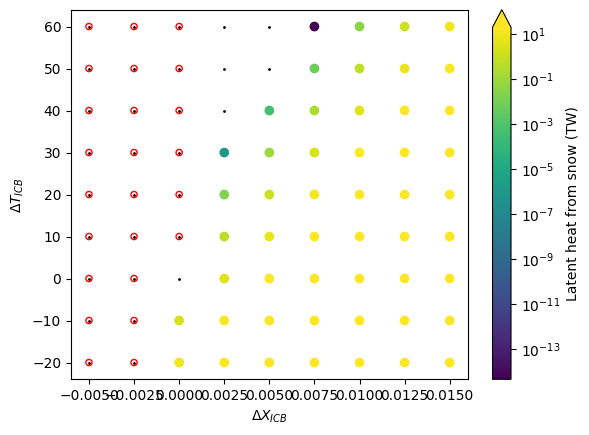

In [9]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
ax.scatter(results_df["dx"], results_df["dt"], color='k', s=1)
ax.scatter(unstable_df["dx"], unstable_df["dt"], s=20, facecolors='none', edgecolors='r')
c = ax.scatter(snow_df["dx"], snow_df["dt"], c=np.array(snow_df["total_latent_heat"])/1.0E12,
              norm=colors.LogNorm(vmax=20), cmap='viridis')
ax.set_ylabel("$\Delta T_{ICB}$")
ax.set_xlabel("$\Delta X_{ICB}$")
#ax.set_ylim(-0.006, 0.006)
fig.colorbar(c, label='Latent heat from snow (TW)', extend='max')
plt.show()


In [10]:
results_df

,dt,dx,N2,dT_liq,dT_cond,total_latent_heat,total_o_rate
0,60.0,0.0150,7.668368e-08,43.848579,128.157535,1.131052e+13,6.426086e+05
1,60.0,0.0125,6.198519e-08,30.003030,128.157535,1.282830e+12,7.389938e+04
2,60.0,0.0100,4.731135e-08,16.194379,128.157535,3.290793e+10,1.923371e+03
3,60.0,0.0075,3.266208e-08,2.422297,128.157535,4.417118e-03,2.619933e-10
4,60.0,0.0050,1.803731e-08,-11.313541,128.157535,NaN,NaN
...,...,...,...,...,...,...,...
76,-20.0,0.0050,3.290851e-08,68.686459,48.157535,8.031049e+13,4.839754e+06
77,-20.0,0.0025,1.829826e-08,54.986542,48.157535,3.605177e+13,2.202252e+06
78,-20.0,0.0000,3.712389e-09,41.322228,48.157535,9.326699e+12,5.775398e+05
79,-20.0,-0.0025,-1.084918e-08,27.693202,48.157535,NaN,NaN


In [11]:
prem = earth_model.Prem()
m_oc = prem.mass(3480.0, r_inner=1221.5)
print(f"Mass of outer core from PREM = {m_oc} kg")
((snow_df["total_o_rate"]*60.0*60.0*24.0*365.0*1.0E9)/m_oc)*100.0

Mass of outer core from PREM = 1.8411154476791537e+24 kg


0     1.100708e+00
1     1.265804e-01
2     3.294494e-03
3     4.487617e-16
9     2.960758e+00
10    6.889638e-01
11    5.889450e-02
12    5.864977e-04
18    5.784237e+00
19    2.203444e+00
20    4.018010e-01
21    2.484841e-02
22    4.480883e-05
27    9.429645e+00
28    4.733743e+00
29    1.558762e+00
30    2.165576e-01
31    8.604222e-03
32    1.136877e-07
36    1.380043e+01
37    8.164091e+00
38    3.770728e+00
39    1.029942e+00
40    1.075761e-01
41    2.199823e-03
45    1.885300e+01
46    1.234639e+01
47    6.949225e+00
48    2.905814e+00
49    6.361498e-01
50    4.931347e-02
54    2.454823e+01
55    1.723660e+01
56    1.094501e+01
57    5.811504e+00
58    2.153613e+00
59    3.660189e-01
63    3.085345e+01
64    2.278196e+01
65    1.566439e+01
66    9.592001e+00
67    4.750270e+00
68    1.510562e+00
69    1.952351e-01
72    3.779266e+01
73    2.899552e+01
74    2.106870e+01
75    1.414268e+01
76    8.289893e+00
77    3.772181e+00
78    9.892533e-01
Name: total_o_rate, dtype: floa

In [17]:
results_df[results_df["dx"] == 0.005][results_df["dt"] == 50.0]

/var/folders/j_/przs7cfj1b7czhv250v8t_440000gn/T/ipykernel_6867/1527972663.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df[results_df["dx"] == 0.005][results_df["dt"] == 50.0]


,dt,dx,N2,dT_liq,dT_cond,total_latent_heat,total_o_rate
13,50.0,0.005,1.989648e-08,-1.313541,118.157535,NaN,NaN


In [15]:
-0.0 < 0.0

False